## 1. Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.9 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
!pip install autocorrect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=5195a88711d36d811c6f8dc21450447ba3b555398d826b2f320f8ea2b1844671
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")

import nltk

# It helps to remove the accented characters
import unidecode

from nltk.tokenize import word_tokenize,sent_tokenize,regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re,string,unicodedata
from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup

# It help to correct the spellings
from autocorrect import Speller

from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay, accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import transformers
import tokenizers

# 2. Data Extraction and Cleaning

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/thought classification/data_thought_new.csv')

In [ ]:
data.head()

,Thought,Label
0,Everyone is probably mad at me,negative
1,You're braver than you believe,positive
2,"When I open my eyes, you're all that I want to...",positive
3,They clearly don’t want to be friends with me ...,negative
4,I've never done it before.,negative


In [ ]:
data.tail()

,Thought,Label
156781,I can't eat spicy food.,negative
156782,Itâ€™s OK to SCREW Up! Nigel Raw,positive
156783,Itâ€™s here. Itâ€™s beautiful. Itâ€™s signed. ...,positive
156784,Stuck On You â€“ Coverrrrr by Alicia Widar,negative
156785,No words for this ðŸ¤¨,negative


In [ ]:
## Assess the shape of the data
print("The Shape of the Dataset",data.shape)

The Shape of the Dataset (156786, 2)


In [ ]:
data.describe()

,Thought,Label
count,156785,156785
unique,129051,2
top,Help,positive
freq,65,85677


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156786 entries, 0 to 156785
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Thought  156785 non-null  object
 1   Label    156785 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


In [ ]:
data['Label'].unique()

array(['negative', 'positive', nan], dtype=object)

In [ ]:
print(data['Label'].value_counts())

positive    85677
negative    71108
Name: Label, dtype: int64


In [ ]:
null_values = data.isnull().sum()  #check null values
print(null_values)

Thought    1
Label      1
dtype: int64


In [ ]:
data = data.dropna(how='any',axis=0) #drop null values

In [ ]:
num_duplicates = data.duplicated().sum() #identify duplicates
print('There are {} duplicate thought present in the dataset'.format(num_duplicates))

There are 27705 duplicate thought present in the dataset


In [ ]:
#view duplicate thoughts
thought = data['Thought']
duplicated_thought = data[thought.isin(thought[thought.duplicated()])].sort_values("Thought")
duplicated_thought.head(20)

In [ ]:
#drop duplicate thoughts
data.drop_duplicates(inplace = True)

In [ ]:
#reseting the index of data frame since some rows have been deleted
data.reset_index(drop=True, inplace=True)

In [ ]:
print('The dataset contains {} rows and {} columns after removing duplicates'.format(data.shape[0],data.shape[1]))

The dataset contains 129080 rows and 2 columns after removing duplicates


In [ ]:
stop = stopwords.words('english')
wl = WordNetLemmatizer()

In [ ]:
mapping = {"ain't": "is not", "aren't": "are not","can't": "can not",
           "'cause": "because", "could've": "could have", "couldn't": "could not",
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will",
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
           "might've": "might have","mightn't": "might not","mightn't've": "might not have",
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
           "she's": "she is", "should've": "should have", "shouldn't": "should not",
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is",
           "there'd": "there would", "there'd've": "there would have", "there's": "there is",
           "here's": "here is","they'd": "they would", "they'd've": "they would have",
           "they'll": "they will", "they'll've": "they will have", "they're": "they are",
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
           "we're": "we are", "we've": "we have", "weren't": "were not",
           "what'll": "what will", "what'll've": "what will have","what're": "what are",
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would",
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
           "you're": "you are", "you've": "you have" }

## Text Preprocessing

### Remove accented characters

In [ ]:
# defining an empty list
text = []

# looping over each message in the data
for i in range(data.shape[0]):

    t = data['Thought'][i].split()
    # Applying the unicode data on a sentence and replacing the accented words to get the closest possible ASCII text
    new_text = [unidecode.unidecode(word) for word in t]

    # Combining the seperate words into sentence
    new_text = ' '.join(new_text)
    # append the new_text to list text
    text.append(new_text)

data['cleaned_text'] = text

### Removing Special Characters

In [ ]:
# defining an empty list
text = []

# looping over each message in the data
for i in range(data.shape[0]):
    words = data['cleaned_text'][i].split() # splitting text into separate words
    new_text = ' '.join([element for element in words if element.isalnum()]) # looping over each element of the list and using the join() function to retrive the original text
    text.append(new_text)  # append the new_text to empty list text

data['cleaned_text'] = text

### Lowercasing

In [ ]:
# defining an empty list
text = []

# looping over each message in the data
for i in range(data.shape[0]):
    # lowecasing the text using the lower() function
    new_text = data['cleaned_text'][i].lower()
    text.append(new_text) # append the new_text to empty list text

data['cleaned_text'] = text

In [ ]:
data.head()

,Thought,Label,cleaned_text
0,Everyone is probably mad at me,negative,everyone is probably mad at me
1,You're braver than you believe,positive,braver than you believe
2,"When I open my eyes, you're all that I want to...",positive,when i open my all that i want to see
3,They clearly don’t want to be friends with me ...,negative,they clearly want to be friends with me anymore
4,I've never done it before.,negative,never done it


In [ ]:
data.tail()

,Thought,Label,cleaned_text
129075,I can't wait to go on vacation next month.,negative,i wait to go on vacation next
129076,Itâ€™s OK to SCREW Up! Nigel Raw,positive,ok to screw nigel raw
129077,Itâ€™s here. Itâ€™s beautiful. Itâ€™s signed. ...,positive,it fits right
129078,Stuck On You â€“ Coverrrrr by Alicia Widar,negative,stuck on you coverrrrr by alicia widar
129079,No words for this ðŸ¤¨,negative,no words for this


### Spellchecking

In [ ]:
"""
# intializing the spellchecker and setting the language to english
spell = Speller(lang = 'en')

# defining a function which will take text as an input break
def autospell(text):
    '''
    A function which takes text as an input, performs a spell check, and autocorrects misspelled words
    text: text input (object)
    '''
    word = text.split() # splitting text into separate words
    spells = [spell(w) for w in word] # Spell checking on each word
    return " ".join(spells) # retriving the original text
"""

'\n# intializing the spellchecker and setting the language to english\nspell = Speller(lang = \'en\')\n\n# defining a function which will take text as an input break\ndef autospell(text):\n    \'\'\'\n    A function which takes text as an input, performs a spell check, and autocorrects misspelled words\n    text: text input (object)\n    \'\'\'\n    word = text.split() # splitting text into separate words\n    spells = [spell(w) for w in word] # Spell checking on each word\n    return " ".join(spells) # retriving the original text\n'

In [ ]:
"""
# defining an empty list
text = []

# looping over each message in the data
for i in range(data.shape[0]):
    # applying the autospell function on the text messages
    new_text = autospell(data['cleaned_text'][i])
    text.append(new_text) # append the new_text to empty list text

data['cleaned_text'] = text
"""

"\n# defining an empty list\ntext = []\n\n# looping over each message in the data\nfor i in range(data.shape[0]):\n    # applying the autospell function on the text messages\n    new_text = autospell(data['cleaned_text'][i])\n    text.append(new_text) # append the new_text to empty list text\n\ndata['cleaned_text'] = text\n"

In [ ]:
# Remove all the special characters
def remove_special_char(text):
    return re.sub('[^A-Za-z0-9]+', ' ', text)

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#expanding chatwords and contracts clearing contractions
def expanding_chatwords(text):
    return ' '.join([mapping[t] if t in mapping else t for t in text.lower().split(" ")])

#emoli clean
def clean_emoji(text):
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_clean.sub(r'',text)

# remove all single characters
def remove_single_char(text):
    return re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

# Remove single characters from the start
def remove_single_char_from_start(text):
    return re.sub(r'\^[a-zA-Z]\s+', ' ', text)

# Substituting multiple spaces with single space
def Sub_multiple_space(text):
    return re.sub(r'\s+', ' ', text, flags=re.I)

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#add space after full stop
def space_after_fullstop(text):
    return re.sub(r'\.(?=\S)', '. ',text)

# Removing URL's
def remove_URL(text):
    return re.sub(r'http\S+', '', text)

#removing punctuation
def remove_punctuation(text):
    return "".join([word.lower() for word in text if word not in string.punctuation])

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)

def tokenization(text):
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop]  #Removing stop words
    return " ".join(filtered_text)


#lemmatize
def lemmatization(text, lemmatize= True):
    if lemmatize:
        return " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()])
    else:
        return " ".join([word for word in text.split() if word not in stop and word.isalpha()])

#Removing the noisy text
def clean_text(text):

    #text = remove_special_char(text)
    text = strip_html(text)
    text = expanding_chatwords(text)
    text = remove_between_square_brackets(text)
    text = clean_emoji(text)
    text = remove_URL(text)
    text = space_after_fullstop(text)
    text = remove_single_char(text)
    text = remove_single_char_from_start(text)
    text = Sub_multiple_space(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = tokenization(text)
    text = lemmatization(text, lemmatize= True)


    return text

In [ ]:
data_copy = data.copy()

In [ ]:
#data['Thought_clean']=data['Thought'].apply(clean_text,lemmatize = True)
data['Thought_clean']=data['cleaned_text'].apply(clean_text)

In [ ]:
data.head()

,Thought,Label,cleaned_text,Thought_clean
0,Everyone is probably mad at me,negative,everyone is probably mad at me,everyone probably mad
1,You're braver than you believe,positive,braver than you believe,braver believe
2,"When I open my eyes, you're all that I want to...",positive,when i open my all that i want to see,open want see
3,They clearly don’t want to be friends with me ...,negative,they clearly want to be friends with me anymore,clearly want friend anymore
4,I've never done it before.,negative,never done it,never done


In [ ]:
data.tail()

,Thought,Label,cleaned_text,Thought_clean
129075,I can't wait to go on vacation next month.,negative,i wait to go on vacation next,wait go vacation next
129076,Itâ€™s OK to SCREW Up! Nigel Raw,positive,ok to screw nigel raw,ok screw nigel raw
129077,Itâ€™s here. Itâ€™s beautiful. Itâ€™s signed. ...,positive,it fits right,fit right
129078,Stuck On You â€“ Coverrrrr by Alicia Widar,negative,stuck on you coverrrrr by alicia widar,stuck coverrrrr alicia widar
129079,No words for this ðŸ¤¨,negative,no words for this,word


## 3. Exploratory data analysis

In [ ]:
print(data['Label'].value_counts())

positive    71185
negative    57895
Name: Label, dtype: int64


In [ ]:
print('Positive thoughts are', (round(data['Label'].value_counts()[0])),'i.e.', round(data['Label'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Negative thoughts are', (round(data['Label'].value_counts()[1])),'i.e.',round(data['Label'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

Positive thoughts are 71185 i.e. 55.15 % of the dataset
Negative thoughts are 57895 i.e. 44.85 % of the dataset


Text(0.5, 1.0, 'Thought Distribution')

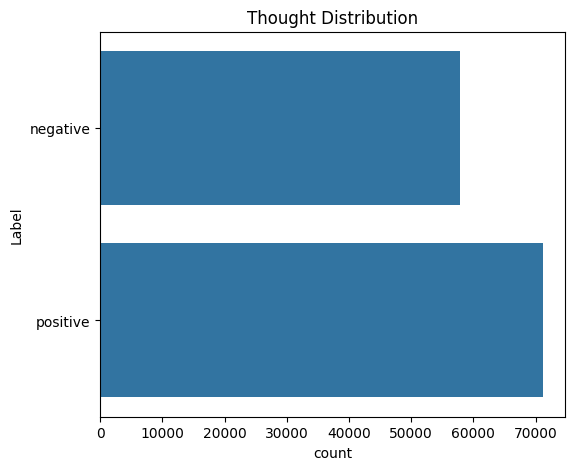

In [ ]:
plt.figure(figsize =(6,5))
sns.countplot(data['Label'])
plt.title("Thought Distribution")

In [ ]:
#converting target variable to numeric labels
data.Label = [ 1 if each == "positive" else 0 for each in data.Label]

## **Predictive Modelling using Deep Learning**

In [ ]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig , ax = plt.subplots(1,2,figsize = (10,5))

  ax[0].plot(epochRange,history.history['accuracy'],label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()
  ax[1].plot(epochRange,history.history['loss'],label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend()
  fig.tight_layout()
  plt.show()

In [ ]:
#splitting into train and test
data_copy['cleaned_text']=data_copy['cleaned_text'].apply(clean_text)
#converting target variable to numerical value
data_copy.Label = [ 1 if each == "positive" else 0 for each in data_copy.Label]
train, test= train_test_split(data_copy, test_size=0.2, random_state=42)
Xtrain, ytrain = train['cleaned_text'], train['Label']
Xtest, ytest = test['cleaned_text'], test['Label']

In [ ]:
#set up the tokenizer
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
tokenizer.fit_on_texts(Xtrain)
word_index = tokenizer.word_index

V = len(word_index)
print("Vocabulary of the dataset is : ",V)

Vocabulary of the dataset is :  31060


In [ ]:
print(word_index)

{'<oov>': 1, 'like': 2, 'help': 3, 'make': 4, 'new': 5, 'feel': 6, 'made': 7, 'find': 8, 'life': 9, 'get': 10, 'need': 11, 'people': 12, 'love': 13, 'best': 14, 'good': 15, 'one': 16, 'positive': 17, 'time': 18, 'know': 19, 'others': 20, 'day': 21, 'feeling': 22, 'would': 23, 'way': 24, 'friend': 25, 'anyone': 26, 'see': 27, 'take': 28, 'want': 29, 'think': 30, 'towards': 31, 'making': 32, 'dream': 33, 'thought': 34, 'every': 35, 'work': 36, 'sense': 37, 'year': 38, 'got': 39, 'world': 40, 'always': 41, 'use': 42, 'thing': 43, 'ability': 44, 'embrace': 45, 'free': 46, 'first': 47, 'never': 48, 'go': 49, 'opportunity': 50, 'please': 51, 'challenge': 52, 'lead': 53, 'believe': 54, 'led': 55, 'even': 56, 'look': 57, 'joy': 58, 'around': 59, 'really': 60, 'u': 61, 'someone': 62, 'could': 63, 'happy': 64, 'hate': 65, 'found': 66, 'support': 67, 'ever': 68, 'better': 69, 'success': 70, 'trust': 71, 'come': 72, 'great': 73, 'create': 74, 'show': 75, 'back': 76, 'little': 77, 'hard': 78, 'bad'

In [ ]:
##create sequences of thoughts
seq_train = tokenizer.texts_to_sequences(Xtrain)
seq_test =  tokenizer.texts_to_sequences(Xtest)

In [ ]:
#choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_train + seq_test]

#if we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

Maximum length of sequence in the list: 64


In [ ]:
# when setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

Maximum length of the sequence when considering data only two standard deviations from average: 12


In [ ]:
perc_covered = np.sum(np.array(seq_len_list) < max_seq_len) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))

The above calculated number coveres approximately 95.25 % of data


**LSTM**

In [ ]:
#create padded sequences
pad_train=pad_sequences(seq_train,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)

In [ ]:
#Splitting training set for validation purposes
Xtrain,Xval,ytrain,yval=train_test_split(pad_train,ytrain,
                                             test_size=0.2,random_state=10)

In [ ]:
def lstm_model(Xtrain,Xval,ytrain,yval,V,D,maxlen,epochs):

    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()

    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

    r = model.fit(Xtrain,ytrain,
                  validation_data = (Xval,yval),
                  epochs = epochs,
                  verbose = 2,
                  batch_size = 32)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(Xtrain,ytrain))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(r.history['loss'])

    return r,model,n_epochs

In [ ]:
D = 64 #embedding dims
epochs = 5
r,model,n_epochs = lstm_model(Xtrain,Xval,ytrain,yval,V,D,max_seq_len,epochs)

----Building the model----
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12)]              0         
                                                                 
 embedding (Embedding)       (None, 12, 64)            1987904   
                                                                 
 batch_normalization (Batch  (None, 12, 64)            256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 12, 64)            0         
                                                                 
 conv1d (Conv1D)             (None, 8, 32)             10272     
                                                                 
 dropout_1 (Dropout)         (None, 8, 32)             0         
                                  

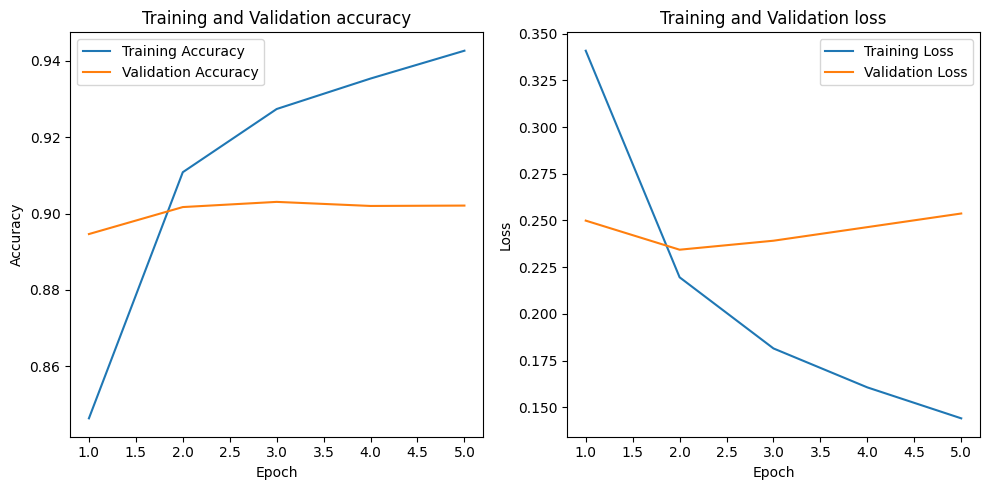

In [ ]:
#Plot accuracy and loss
plotLearningCurve(r,n_epochs)

In [ ]:
print("Evaluate LSTM Model Performance on Test set")
result = model.evaluate(pad_test,ytest)
print(dict(zip(model.metrics_names, result)))

Evaluate LSTM Model Performance on Test set
807/807 [==============================] - 5s 6ms/step - loss: 0.2531 - accuracy: 0.9054
{'loss': 0.253051221370697, 'accuracy': 0.9053687453269958}


807/807 [==============================] - 6s 5ms/step


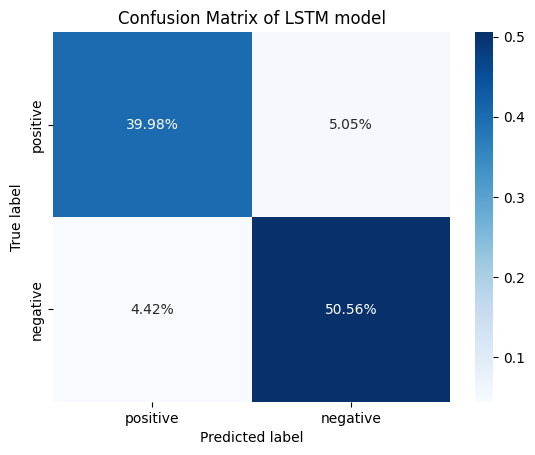

In [ ]:
#Generate predictions for the test dataset
ypred = model.predict(pad_test)
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(ytest, ypred)
sns.heatmap(cf_matrix/np.sum(cf_matrix),annot = True,fmt ='.2%', cmap='Blues', xticklabels=['positive','negative'], yticklabels=['positive','negative'])
plt.title("Confusion Matrix of LSTM model")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
print(classification_report(ytest,ypred,target_names=['Positive','Negative']))

              precision    recall  f1-score   support

    Positive       0.90      0.89      0.89     11624
    Negative       0.91      0.92      0.91     14192

    accuracy                           0.91     25816
   macro avg       0.90      0.90      0.90     25816
weighted avg       0.91      0.91      0.91     25816



**BERT**

In [ ]:
train, test= train_test_split(data_copy, test_size=0.2, random_state=42)
Xtrain, ytrain = train['cleaned_text'], train['Label']
Xtest, ytest = test['cleaned_text'], test['Label']
#splitting the train set into train and validation
Xtrain,Xval,ytrain,yval=train_test_split(Xtrain,ytrain,
                                             test_size=0.2,random_state=10)

In [ ]:
#Perform tokenization
# automatically download the vocab used during pretraining or fine-tuning a given model,use from_pretrained() method

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
#pass our texts to the tokenizer.
Xtrain_enc = tokenizer(Xtrain.tolist(), max_length=max_seq_len,
                         truncation=True, padding='max_length',
                         add_special_tokens=True, return_tensors='tf') #return numpy object
Xval_enc = tokenizer(Xval.tolist(), max_length=max_seq_len,
                         truncation=True, padding='max_length',
                         add_special_tokens=True, return_tensors='tf') #return numpy object
Xtest_enc = tokenizer(Xtest.tolist(), max_length=max_seq_len,
                         truncation=True, padding='max_length',
                         add_special_tokens=True, return_tensors='tf') #return numpy object

In [ ]:
#preparing our datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtrain_enc),
    ytrain
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xval_enc),
    yval
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtest_enc),
    ytest
))

In [ ]:
def bert_model(train_dataset,val_dataset,transformer,max_len,epochs):
    print("----Building the model----")
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,),dtype=tf.int32,name = 'attention_mask') #attention mask
    sequence_output = transformer(input_ids,attention_mask)[0]
    cls_token = sequence_output[:, 0, :]

    x = Dense(128, activation='relu')(cls_token)

    x = Dropout(0.5)(x)

    y = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[input_ids,attention_mask], outputs=y)
    model.summary()
    model.compile(Adam(learning_rate=1.5e-5), loss='binary_crossentropy', metrics=['accuracy'])
    r = model.fit(train_dataset.batch(12),batch_size = 12, validation_data = val_dataset.batch(12),epochs = epochs)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(train_dataset.batch(12)))
    print("Validation score:", model.evaluate(val_dataset.batch(12)))
    n_epochs = len(r.history['loss'])

    return r,model,n_epochs

In [ ]:
transformer = transformers.TFBertModel.from_pretrained('bert-base-uncased', resume_download=True)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
epochs = 2
max_len = max_seq_len
r,model,n_epochs = bert_model(train_dataset,val_dataset,transformer,max_len,epochs)

----Building the model----
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 12)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 12)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 12, 76          

6885/6885 [==============================] - 6630s 959ms/step - loss: 0.2754 - accuracy: 0.8861 - val_loss: 0.2188 - val_accuracy: 0.9112
Epoch 2/2
6885/6885 [==============================] - 1454s 211ms/step - loss: 0.1036 - accuracy: 0.9598
Train score: [0.10363560914993286, 0.959823727607727]
1722/1722 [==============================] - 365s 212ms/step - loss: 0.2234 - accuracy: 0.9148
Validation score: [0.22340133786201477, 0.9148308038711548]


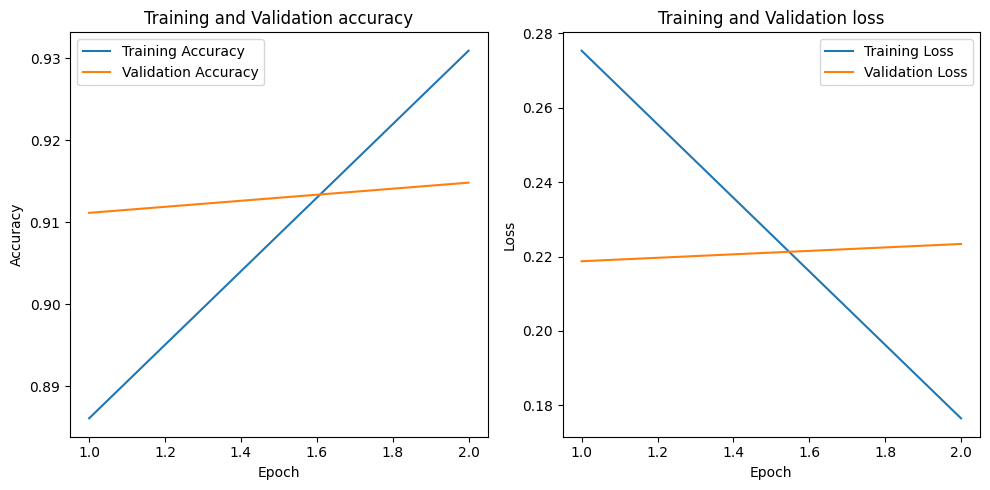

In [ ]:
#Plot accuracy and loss
plotLearningCurve(r,n_epochs)

In [ ]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(test_dataset.batch(32))
print(dict(zip(model.metrics_names, result)))

Evaluate Model Performance on Test set
807/807 [==============================] - 322s 399ms/step - loss: 0.2173 - accuracy: 0.9159
{'loss': 0.21726928651332855, 'accuracy': 0.9159048795700073}


2152/2152 [==============================] - 453s 209ms/step


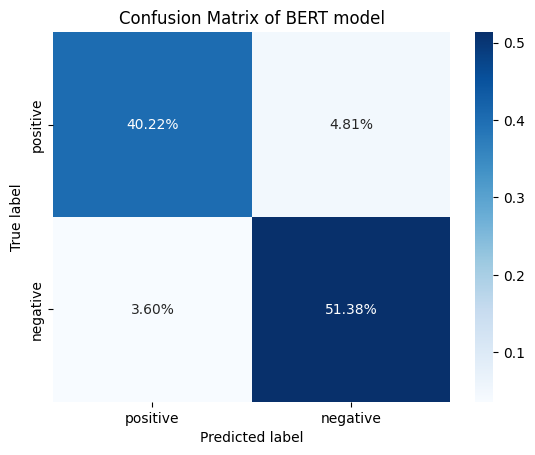

In [ ]:
#Generate predictions for the test dataset
ypred = model.predict(test_dataset.batch(12))
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(ytest, ypred)
#sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues', xticklabels=['positive','negative'], yticklabels=['positive','negative'])
sns.heatmap(cf_matrix/np.sum(cf_matrix),annot = True,fmt ='.2%', cmap='Blues', xticklabels=['positive','negative'], yticklabels=['positive','negative'])
plt.title("Confusion Matrix of BERT model")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
print(classification_report(ytest,ypred,target_names=['Positive','Negative']))

              precision    recall  f1-score   support

    Positive       0.92      0.89      0.91     11624
    Negative       0.91      0.93      0.92     14192

    accuracy                           0.92     25816
   macro avg       0.92      0.91      0.91     25816
weighted avg       0.92      0.92      0.92     25816



### **Distilbert Model**

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
#pass our texts to the tokenizer.
Xtrain_enc = tokenizer(Xtrain.tolist(), max_length=max_seq_len,
                         truncation=True, padding='max_length',
                         add_special_tokens=True, return_tensors='tf') #return numpy object
Xval_enc = tokenizer(Xval.tolist(), max_length=max_seq_len,
                         truncation=True, padding='max_length',
                         add_special_tokens=True, return_tensors='tf') #return numpy object
Xtest_enc = tokenizer(Xtest.tolist(), max_length=max_seq_len,
                         truncation=True, padding='max_length',
                         add_special_tokens=True, return_tensors='tf') #return numpy object

In [ ]:
#preparing our datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtrain_enc),
    ytrain
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xval_enc),
    yval
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtest_enc),
    ytest
))

In [ ]:
transformer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', resume_download=True)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
epochs = 2
max_len = max_seq_len
r,model,n_epochs = bert_model(train_dataset,val_dataset,transformer,max_len,epochs)

----Building the model----
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 12)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 12)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 stilBertModel)              den_state=(None, 12, 768),   0          'attention_mask[0][0]']      
                              hidden_states=None, atten            

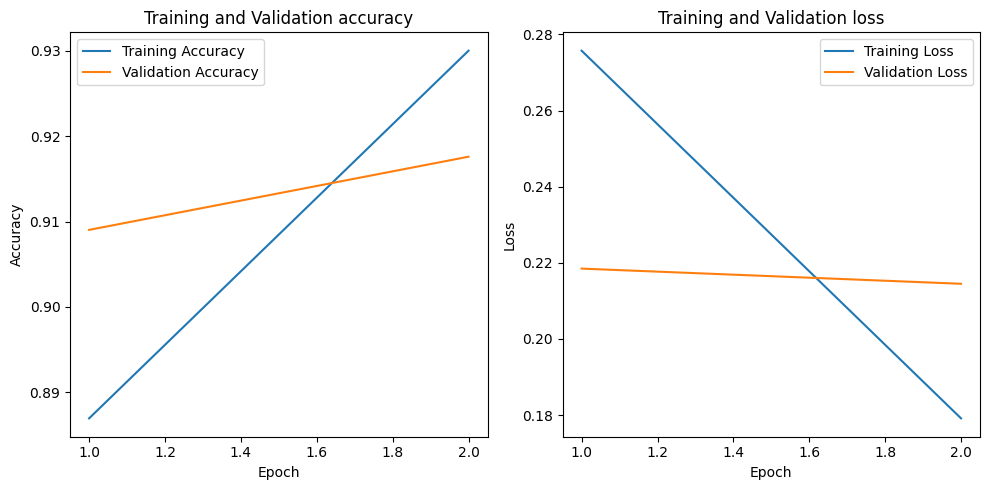

In [ ]:
#Plot accuracy and loss
plotLearningCurve(r,n_epochs)

In [ ]:
print("Evaluate DistilBert Model Performance on Test set")
result = model.evaluate(test_dataset.batch(32))
print(dict(zip(model.metrics_names, result)))

Evaluate DistilBert Model Performance on Test set
807/807 [==============================] - 565s 700ms/step - loss: 0.2114 - accuracy: 0.9163
{'loss': 0.21140871942043304, 'accuracy': 0.9162535071372986}


2152/2152 [==============================] - 662s 308ms/step


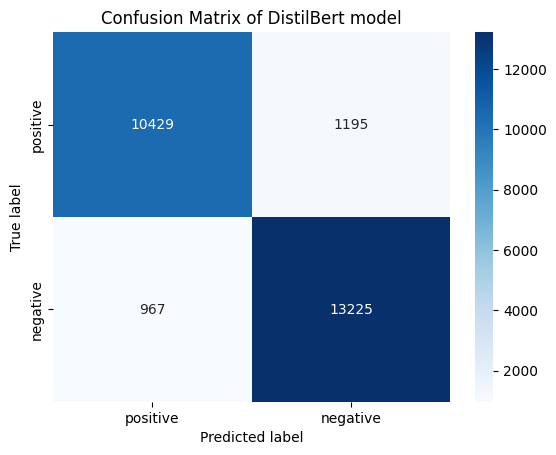

In [ ]:
#Generate predictions for the test dataset
ypred = model.predict(test_dataset.batch(12))
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(ytest, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues', xticklabels=['positive','negative'], yticklabels=['positive','negative'])
#sns.heatmap(cf_matrix/np.sum(cf_matrix),annot = True,fmt ='.2%', cmap='Blues', xticklabels=['positive','negative'], yticklabels=['positive','negative'])
plt.title("Confusion Matrix of DistilBert model")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
print(classification_report(ytest,ypred,target_names=['Positive','Negative']))

              precision    recall  f1-score   support

    Positive       0.92      0.90      0.91     11624
    Negative       0.92      0.93      0.92     14192

    accuracy                           0.92     25816
   macro avg       0.92      0.91      0.92     25816
weighted avg       0.92      0.92      0.92     25816



### **RoBERTa Model**

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained('roberta-base')

In [ ]:
#pass our texts to the tokenizer.
Xtrain_enc = tokenizer(Xtrain.tolist(), max_length=max_seq_len,
                         truncation=True, padding='max_length',
                         add_special_tokens=True, return_tensors='tf') #return numpy object
Xval_enc = tokenizer(Xval.tolist(), max_length=max_seq_len,
                         truncation=True, padding='max_length',
                         add_special_tokens=True, return_tensors='tf') #return numpy object
Xtest_enc = tokenizer(Xtest.tolist(), max_length=max_seq_len,
                         truncation=True, padding='max_length',
                         add_special_tokens=True, return_tensors='tf') #return numpy object

In [ ]:
#preparing our datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtrain_enc),
    ytrain
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xval_enc),
    yval
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtest_enc),
    ytest
))

In [ ]:
transformer = transformers.TFRobertaModel.from_pretrained('roberta-base', resume_download=True)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [ ]:
epochs = 2
max_len = max_seq_len
r,model,n_epochs = bert_model(train_dataset,val_dataset,transformer,max_len,epochs)

----Building the model----
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 12)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 12)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_ids[0][0]',           
 aModel)                     ngAndCrossAttentions(last_   32         'attention_mask[0][0]']      
                             hidden_state=(None, 12, 76          

6885/6885 [==============================] - 7476s 1s/step - loss: 0.1840 - accuracy: 0.9278 - val_loss: 0.2259 - val_accuracy: 0.9096
Epoch 2/2
6885/6885 [==============================] - 1405s 204ms/step - loss: 0.0988 - accuracy: 0.9631
Train score: [0.09880995005369186, 0.9630920886993408]
1722/1722 [==============================] - 354s 206ms/step - loss: 0.2333 - accuracy: 0.9112
Validation score: [0.23329895734786987, 0.9112477898597717]


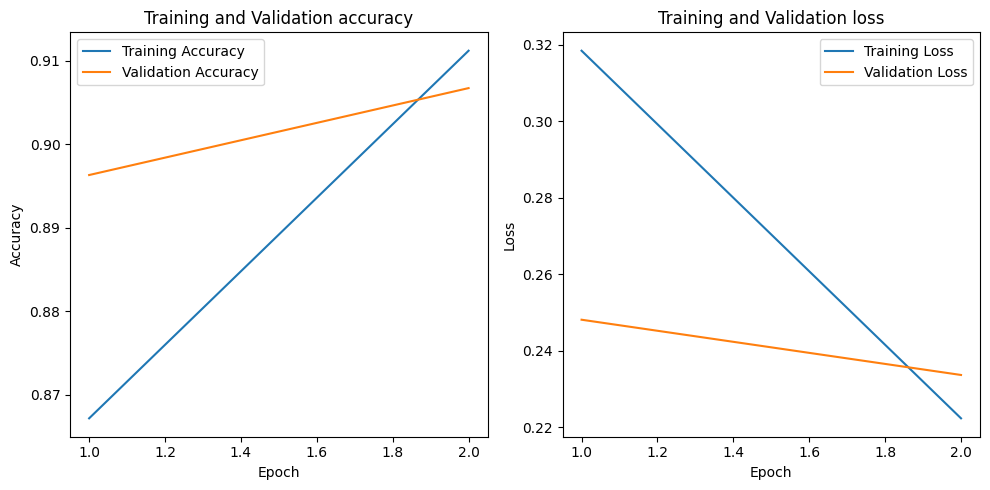

In [ ]:
#Plot accuracy and loss
plotLearningCurve(r,n_epochs)

In [ ]:
print("Evaluate RoBERTa Model Performance on Test set")
result = model.evaluate(test_dataset.batch(32))
print(dict(zip(model.metrics_names, result)))

Evaluate RoBERTa Model Performance on Test set
807/807 [==============================] - 331s 410ms/step - loss: 0.2306 - accuracy: 0.9091
{'loss': 0.23064874112606049, 'accuracy': 0.9090873599052429}


2152/2152 [==============================] - 452s 208ms/step


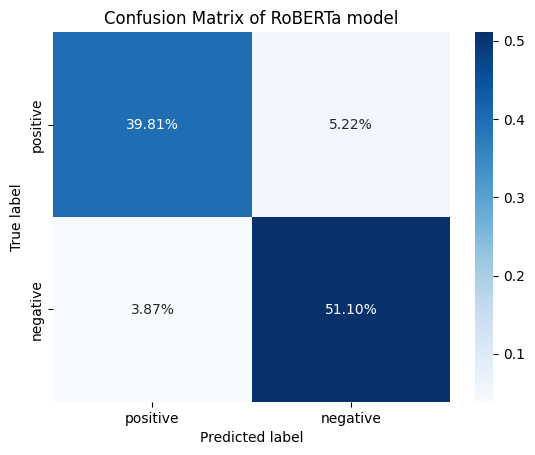

In [ ]:
#Generate predictions for the test dataset
ypred = model.predict(test_dataset.batch(12))
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(ytest, ypred)
sns.heatmap(cf_matrix/np.sum(cf_matrix),annot = True,fmt ='.2%', cmap='Blues', xticklabels=['positive','negative'], yticklabels=['positive','negative'])
plt.title("Confusion Matrix of RoBERTa model")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
print(classification_report(ytest,ypred,target_names=['Positive','Negative']))

              precision    recall  f1-score   support

    Positive       0.91      0.88      0.90     11624
    Negative       0.91      0.93      0.92     14192

    accuracy                           0.91     25816
   macro avg       0.91      0.91      0.91     25816
weighted avg       0.91      0.91      0.91     25816



### **ALBERT**

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained('albert-base-v2')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

In [ ]:
#pass our texts to the tokenizer.
Xtrain_enc = tokenizer(Xtrain.tolist(), max_length=max_seq_len,
                         truncation=True, padding='max_length',
                         add_special_tokens=True, return_tensors='tf') #return numpy object
Xval_enc = tokenizer(Xval.tolist(), max_length=max_seq_len,
                         truncation=True, padding='max_length',
                         add_special_tokens=True, return_tensors='tf') #return numpy object
Xtest_enc = tokenizer(Xtest.tolist(), max_length=max_seq_len,
                         truncation=True, padding='max_length',
                         add_special_tokens=True, return_tensors='tf') #return numpy object

In [ ]:
#preparing our datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtrain_enc),
    ytrain
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xval_enc),
    yval
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtest_enc),
    ytest
))

In [ ]:
transformer = transformers.TFAlbertModel.from_pretrained('albert-base-v2', resume_download=True)

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.dense.bias', 'predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


In [ ]:
epochs = 2
max_len = max_seq_len
r,model,n_epochs = bert_model(train_dataset,val_dataset,transformer,max_len,epochs)

----Building the model----
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 12)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 12)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_albert_model (TFAlbertM  TFBaseModelOutputWithPooli   1168358   ['input_ids[0][0]',           
 odel)                       ng(last_hidden_state=(None   4          'attention_mask[0][0]']      
                             , 12, 768),                           

6885/6885 [==============================] - 523s 73ms/step - loss: 0.3142 - accuracy: 0.8700 - val_loss: 0.2602 - val_accuracy: 0.8907
Epoch 2/2
6885/6885 [==============================] - 207s 30ms/step - loss: 0.1722 - accuracy: 0.9320
Train score: [0.17224492132663727, 0.9319581985473633]
1722/1722 [==============================] - 52s 30ms/step - loss: 0.2277 - accuracy: 0.9080
Validation score: [0.22770176827907562, 0.9079552888870239]


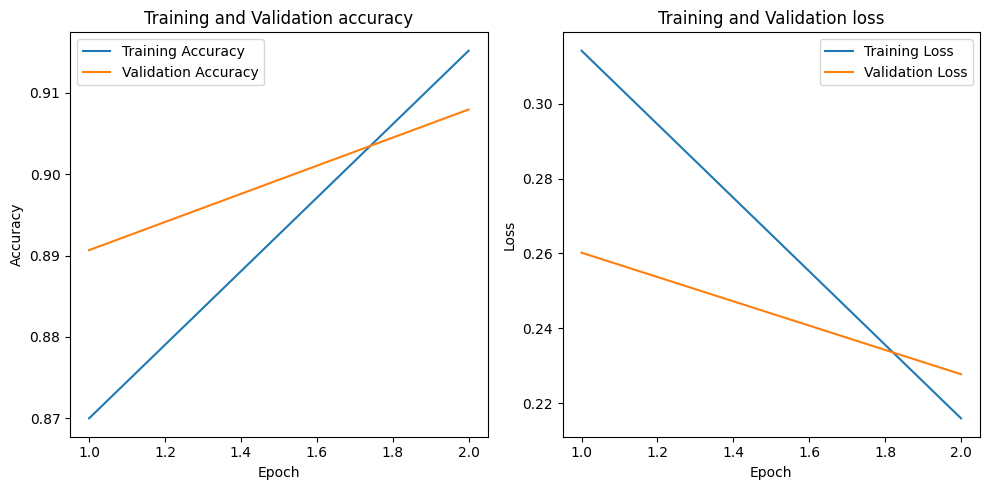

In [ ]:
#Plot accuracy and loss
plotLearningCurve(r,n_epochs)

In [ ]:
print("Evaluate ALBERT Model Performance on Test set")
result = model.evaluate(test_dataset.batch(32))
print(dict(zip(model.metrics_names, result)))

Evaluate ALBERT Model Performance on Test set
807/807 [==============================] - 34s 42ms/step - loss: 0.2234 - accuracy: 0.9079
{'loss': 0.22341205179691315, 'accuracy': 0.9079253077507019}


2152/2152 [==============================] - 66s 29ms/step


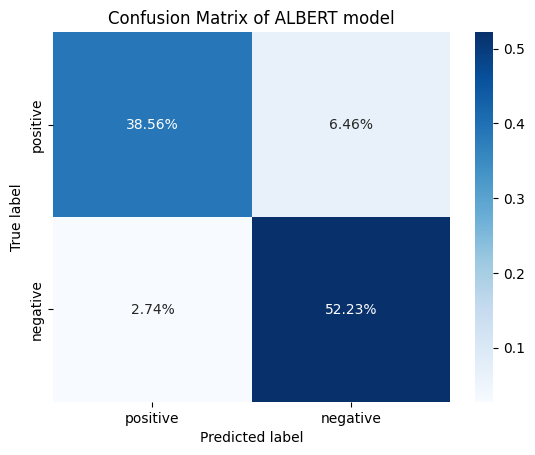

In [ ]:
#Generate predictions for the test dataset
ypred = model.predict(test_dataset.batch(12))
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(ytest, ypred)
sns.heatmap(cf_matrix/np.sum(cf_matrix),annot = True,fmt ='.2%', cmap='Blues', xticklabels=['positive','negative'], yticklabels=['positive','negative'])
plt.title("Confusion Matrix of ALBERT model")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
print(classification_report(ytest,ypred,target_names=['Positive','Negative']))

              precision    recall  f1-score   support

    Positive       0.93      0.86      0.89     11624
    Negative       0.89      0.95      0.92     14192

    accuracy                           0.91     25816
   macro avg       0.91      0.90      0.91     25816
weighted avg       0.91      0.91      0.91     25816

